## Setup


In [181]:
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette('cividis')

# data partition

# encoding

warnings.filterwarnings('ignore')

In [86]:
train_path = os.path.join("..", "data", "input", "train.csv")
test_path = os.path.join("..", "data", "input", "test.csv")

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

df.set_index("encounter_id", inplace=True)
test_df.set_index("encounter_id", inplace=True)

In [87]:
df.head().T

encounter_id,533253,426224,634063,890610,654194
country,USA,USA,USA,USA,USA
patient_id,70110,29775006,80729253,2919042,84871971
race,Caucasian,AfricanAmerican,Caucasian,AfricanAmerican,Caucasian
gender,Female,Male,Female,Male,Female
age,[70-80),[50-60),[60-70),[60-70),[70-80)
weight,?,?,?,?,?
payer_code,?,?,?,MC,HM
outpatient_visits_in_previous_year,0,0,0,0,1
emergency_visits_in_previous_year,0,0,0,0,0
inpatient_visits_in_previous_year,2,0,1,1,0


## Data exploration and pre-processing


In [88]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,71236,1,USA,71236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
patient_id,71236.0,NaN,NaN,NaN,54302279.330984,38795850.347332,135.0,23396510.25,45305631.0,87558374.25,189502619.0
race,67682,6,Caucasian,50693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,71236,3,Female,38228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,67679,10,[70-80),17359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,71236,10,?,68990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payer_code,71236,18,?,28201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outpatient_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.369588,1.287469,0.0,0.0,0.0,0.0,42.0
emergency_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.196249,0.910854,0.0,0.0,0.0,0.0,76.0
inpatient_visits_in_previous_year,71236.0,NaN,NaN,NaN,0.640154,1.267271,0.0,0.0,0.0,1.0,21.0


**note:** something weird that needs to be treated is that if is it possible there are no _missing values_ on all of the metric features. maybe check the excel file and see how `.read_csv` is parsing the data.


In [89]:
df.duplicated().sum()

0

### Treatment of missing values and scarce values


since we noticed that there are a lot of `?` we are going to replace all with `np.nan`, to see the quantity of missing values


In [90]:
df.replace("?", np.nan, inplace=True)
test_df.replace("?", np.nan, inplace=True)

df.isna().sum()[df.isnull().sum() > 1] / len(df) * 100

race                      7.117188
age                       4.993262
weight                   96.847100
payer_code               39.588130
admission_type            5.202426
medical_specialty        49.022966
discharge_disposition     3.635802
admission_source          6.623056
primary_diagnosis         0.022461
secondary_diagnosis       0.367792
additional_diagnosis      1.415015
glucose_test_result      94.822842
a1c_test_result          83.272503
dtype: float64

In [91]:
print("a1c", df["a1c_test_result"].unique())
print("glucose", df["glucose_test_result"].unique())

a1c [nan 'Norm' '>8' '>7']
glucose [nan '>300' 'Norm' '>200']


according to the documentation provided, the possible values in a1c and glucose tests, contain a "none".

so, the approach that we are taking is to replace the nans of these columns with a "none", since probably both of this columns could have an impact on the target variable


In [92]:
df.loc[:, ["a1c_test_result", "glucose_test_result"]] = df.loc[:, [
    "a1c_test_result", "glucose_test_result"]].replace(np.nan, "none")
test_df.loc[:, ["a1c_test_result", "glucose_test_result"]] = test_df.loc[:, [
    "a1c_test_result", "glucose_test_result"]].replace(np.nan, "none")

print("a1c", df["a1c_test_result"].unique())
print("glucose", df["glucose_test_result"].unique())

a1c ['none' 'Norm' '>8' '>7']
glucose ['none' '>300' 'Norm' '>200']


values that are not common in the feature, we will replace with np.nan


In [93]:
df["admission_type"].replace("Not Available", np.nan, inplace=True)
df["admission_type"].replace("Not Mapped", np.nan, inplace=True)
df["discharge_disposition"].replace("Not Mapped", np.nan, inplace=True)
df["gender"].replace("Unknown/Invalid", np.nan, inplace=True)
df["admission_source"].replace("Not Available", np.nan, inplace=True)
df['medical_specialty'].replace('PhysicianNotFound', np.nan, inplace=True)

test_df["admission_type"].replace("Not Available", np.nan, inplace=True)
test_df["admission_type"].replace("Not Mapped", np.nan, inplace=True)
test_df["discharge_disposition"].replace("Not Mapped", np.nan, inplace=True)
test_df["gender"].replace("Unknown/Invalid", np.nan, inplace=True)
test_df["admission_source"].replace("Not Available", np.nan, inplace=True)
test_df['medical_specialty'].replace('PhysicianNotFound', np.nan, inplace=True)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71236 entries, 533253 to 459757
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                71236 non-null  object
 1   patient_id                             71236 non-null  int64 
 2   race                                   66166 non-null  object
 3   gender                                 71233 non-null  object
 4   age                                    67679 non-null  object
 5   weight                                 2246 non-null   object
 6   payer_code                             43035 non-null  object
 7   outpatient_visits_in_previous_year     71236 non-null  int64 
 8   emergency_visits_in_previous_year      71236 non-null  int64 
 9   inpatient_visits_in_previous_year      71236 non-null  int64 
 10  admission_type                         63996 non-null  object
 11  medical_specia

### Data Exploration


In [95]:
metric_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns

metric_features = metric_features.drop(["patient_id"])

print(metric_features)
print(categorical_features)

Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses'],
      dtype='object')
Index(['country', 'race', 'gender', 'age', 'weight', 'payer_code',
       'admission_type', 'medical_specialty', 'discharge_disposition',
       'admission_source', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass'],
      dtype='object')


#### Metric Features Analysis


In [96]:
metric_report = df[metric_features].describe().T
metric_report['cardinality'] = df[metric_features].nunique()

metric_report

,count,mean,std,min,25%,50%,75%,max,cardinality
outpatient_visits_in_previous_year,71236.0,0.369588,1.287469,0.0,0.0,0.0,0.0,42.0,38
emergency_visits_in_previous_year,71236.0,0.196249,0.910854,0.0,0.0,0.0,0.0,76.0,30
inpatient_visits_in_previous_year,71236.0,0.640154,1.267271,0.0,0.0,0.0,1.0,21.0,21
average_pulse_bpm,71236.0,99.611222,23.040521,60.0,80.0,100.0,119.0,139.0,80
length_of_stay_in_hospital,71236.0,4.391024,2.988739,1.0,2.0,4.0,6.0,14.0,14
number_lab_tests,71236.0,43.095654,19.642919,1.0,31.0,44.0,57.0,121.0,114
non_lab_procedures,71236.0,1.340923,1.706664,0.0,0.0,1.0,2.0,6.0,7
number_of_medications,71236.0,15.995452,8.122347,1.0,10.0,15.0,20.0,75.0,72
number_diagnoses,71236.0,7.421023,1.937809,1.0,6.0,8.0,9.0,16.0,16


some insights from the data:

- since for `outpatient`, `emergency`, and `inpatient` visits a lot of 0 are concentrated up to 75% of the data, probably we should turn them to a dummy
  - ex: `outpatient_visitis` -> `is_outpatient_visited` [0, 1]


##### Graph Analysis


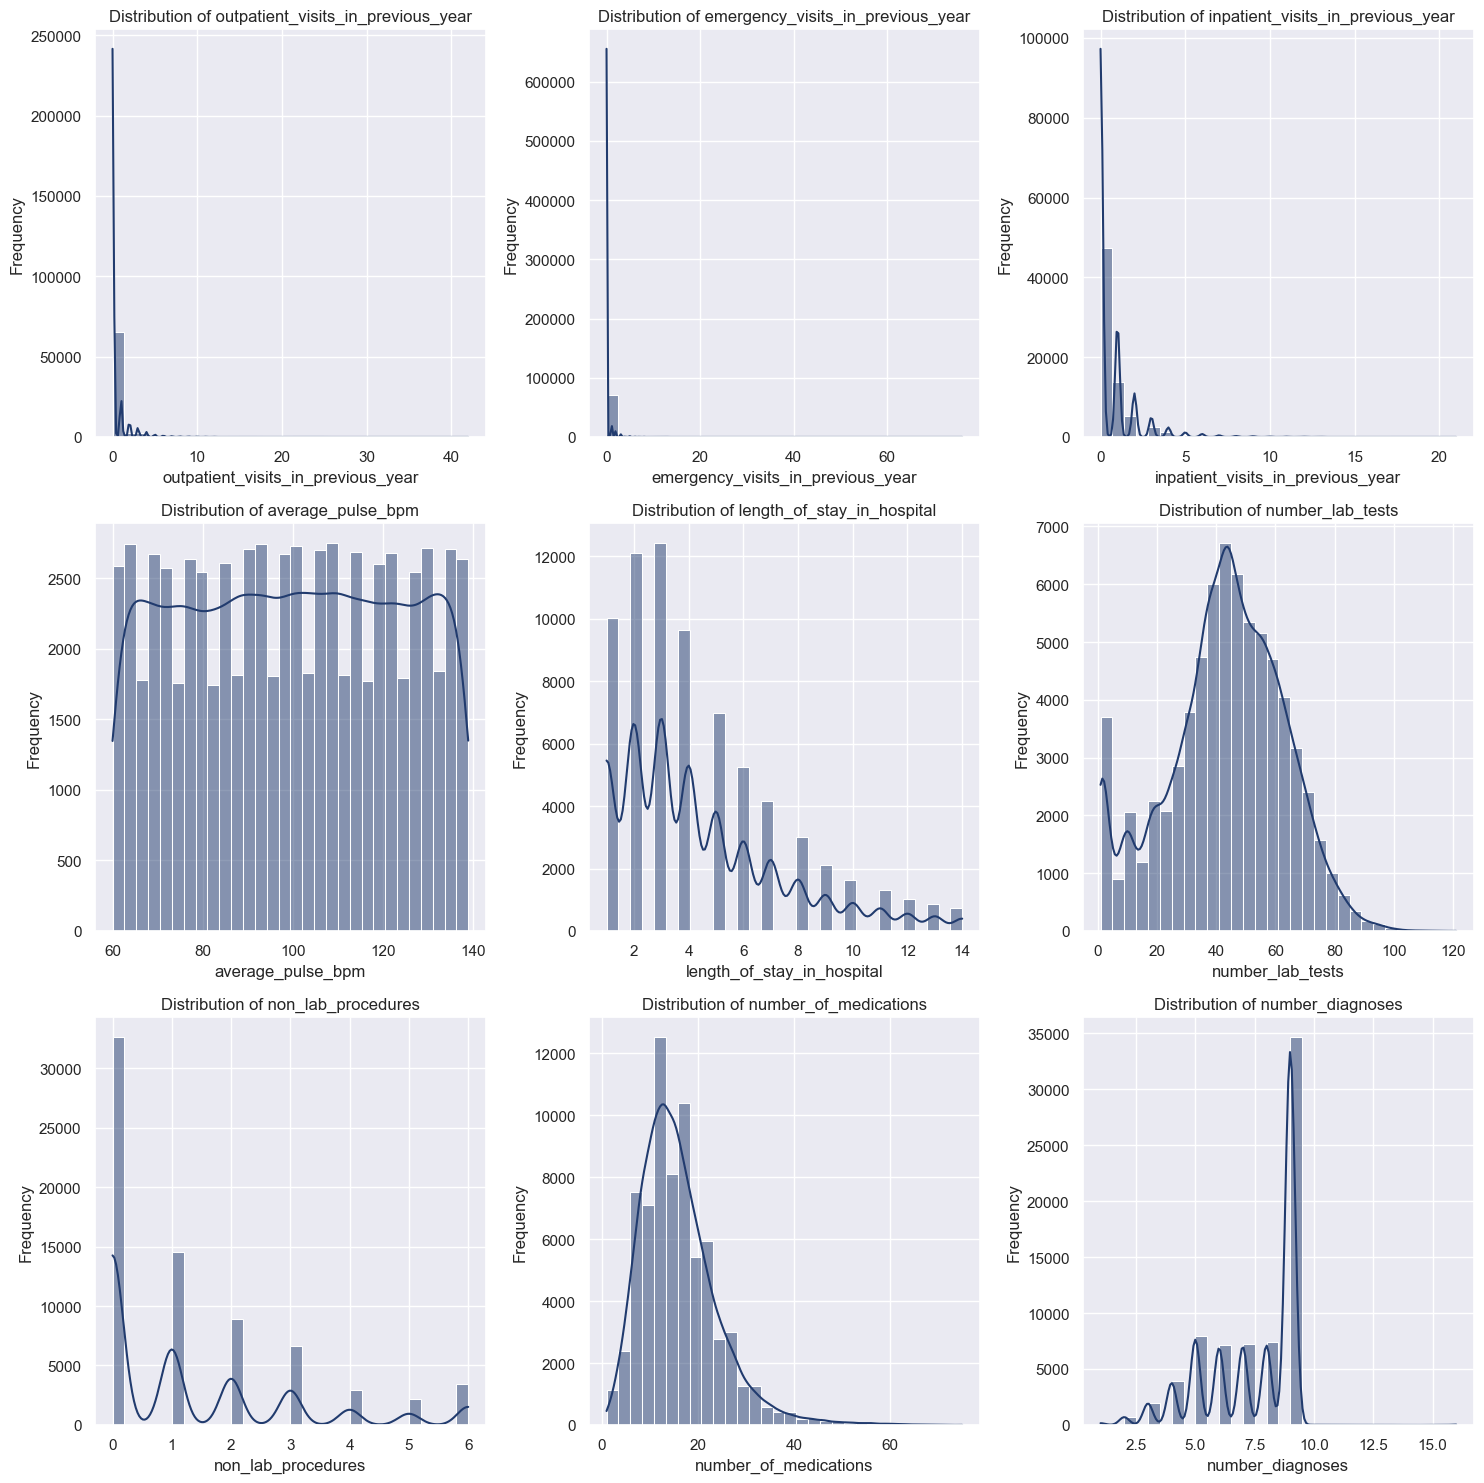

In [97]:
plots_per_row = 3

num_plots = len(metric_features)
num_rows = num_plots // plots_per_row + (1 if num_plots % plots_per_row else 0)

# Creating the plot
plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(metric_features, 1):
    plt.subplot(num_rows, plots_per_row, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

some insights given the graphs:

- `length_of_stay`, `number_lab_tests`, and `number of medications` look like skewed normal distributions, probably no data treatment needed there.
- `number_of_diagnosis` and `non_lab_procedures` maybe can be treated as ordinals? since there are very few categories
- `averge_bpm` looks like invariant, research
- `x_in_previous_year` as metioned above, a possibility could be to create a new feature that is binomial, of whether is 0 or not.


#### Categorical Features Analysis


In [98]:
def describe_categorical(features, dataframe):
    # Initialize lists to store data for each column in the report
    feature_list = []
    mode_list = []
    mode_freq_list = []
    mode_prop_list = []
    second_mode_list = []
    second_mode_freq_list = []
    second_mode_prop_list = []
    missing_val_percent_list = []
    cardinality_list = []

    for feature in features:
        # Calculate mode, 2nd mode and their frequencies
        mode = dataframe[feature].mode()[0]
        mode_freq = dataframe[feature].value_counts().iloc[0]
        mode_prop = mode_freq / len(dataframe)
        second_mode = dataframe[feature].value_counts().index[1] if len(
            dataframe[feature].value_counts()) > 1 else 'N/A'
        second_mode_freq = dataframe[feature].value_counts().iloc[1] if len(
            dataframe[feature].value_counts()) > 1 else 0
        second_mode_prop = second_mode_freq / len(dataframe)

        # Calculate missing values percentage and cardinality
        missing_val_percent = dataframe[feature].isna().mean() * 100
        cardinality = dataframe[feature].nunique()

        # Append to lists
        feature_list.append(feature)
        mode_list.append(mode)
        mode_freq_list.append(mode_freq)
        mode_prop_list.append(mode_prop)
        second_mode_list.append(second_mode)
        second_mode_freq_list.append(second_mode_freq)
        second_mode_prop_list.append(second_mode_prop)
        missing_val_percent_list.append(missing_val_percent)
        cardinality_list.append(cardinality)

    # Create the DataFrame
    categorical_data_quality_report = pd.DataFrame({
        'Feature': feature_list,
        'Mode': mode_list,
        'Mode Frequency': mode_freq_list,
        'Mode Proportion': mode_prop_list,
        '2nd Mode': second_mode_list,
        '2nd Mode Frequency': second_mode_freq_list,
        '2nd Mode Proportion': second_mode_prop_list,
        'Missing Values %': missing_val_percent_list,
        'Cardinality': cardinality_list
    })

    return categorical_data_quality_report.sort_values(by=['Mode Proportion', 'Missing Values %'], ascending=False)

In [99]:
cat_info = describe_categorical(categorical_features, df).set_index("Feature")
cat_info.sort_values('Cardinality')

,Mode,Mode Frequency,Mode Proportion,2nd Mode,2nd Mode Frequency,2nd Mode Proportion,Missing Values %,Cardinality
Feature,,,,,,,,
country,USA,71236,1.000000,N/A,0,0.000000,0.000000,1
gender,Female,38228,0.536639,Male,33005,0.463319,0.004211,2
prescribed_diabetes_meds,Yes,54890,0.770537,No,16346,0.229463,0.000000,2
change_in_meds_during_hospitalization,No,38326,0.538014,Ch,32910,0.461986,0.000000,2
readmitted_binary,No,63286,0.888399,Yes,7950,0.111601,0.000000,2
readmitted_multiclass,No,38405,0.539123,>30 days,24881,0.349276,0.000000,3
glucose_test_result,none,67548,0.948228,Norm,1806,0.025352,0.000000,4
a1c_test_result,none,59320,0.832725,>8,5705,0.080086,0.000000,4
race,Caucasian,50693,0.711621,AfricanAmerican,12693,0.178182,7.117188,5


**insights**:

- `usa` invariant (we should drop)
- `glucose_test_result` and `a1c` (dominated by none)
- top 3 missing values:
  1. `weight` (we should drop)
  2. `medical_specialty`
  3. `payer_code`
- seems that `gender` and `change_in_meds` are the only ones that are boolean


##### Graphical Analysis


Index(['payer_code', 'medical_specialty', 'discharge_disposition',
       'admission_source', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'medication'],
      dtype='object')


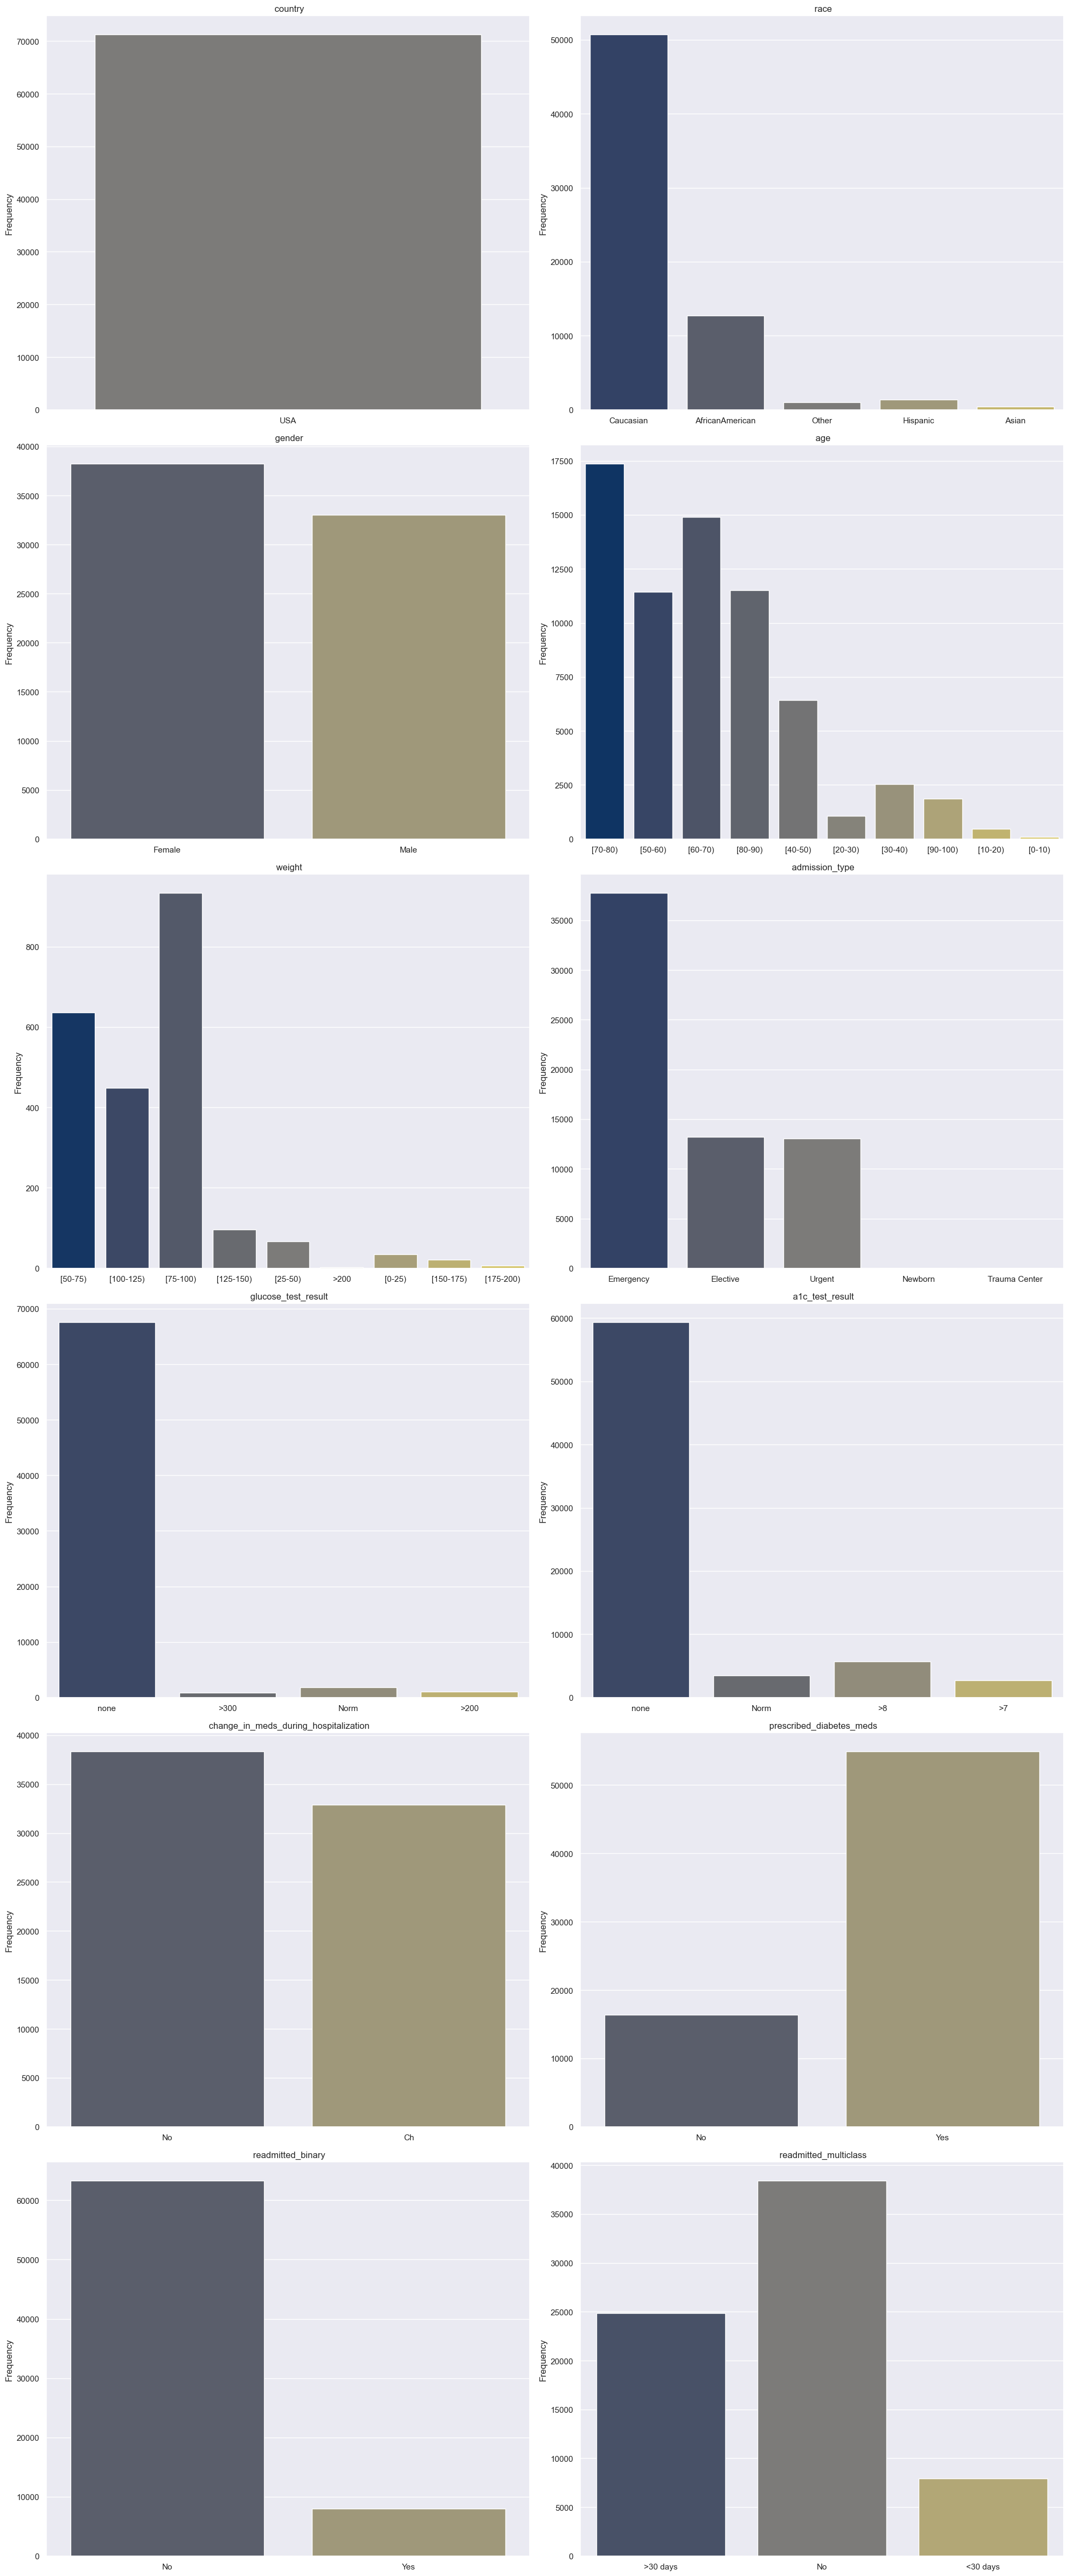

In [100]:
# Filtering out categorical features with low cardinality for visualization
low_cardinality_features = [
    feature for feature in categorical_features if cat_info.loc[feature, "Cardinality"] <= 10]

print(categorical_features[~categorical_features.isin(
    low_cardinality_features)])

# Adjusting the layout to display 2 bar plots per row for low cardinality features and increasing plot size
plots_per_row_low_cardinality = 2
num_rows_low_cardinality = len(low_cardinality_features) // plots_per_row_low_cardinality + \
    (1 if len(low_cardinality_features) % plots_per_row_low_cardinality else 0)

plt.figure(figsize=(20, num_rows_low_cardinality * 8))  # Increased figure size

for i, feature in enumerate(low_cardinality_features, 1):
    plt.subplot(num_rows_low_cardinality, plots_per_row_low_cardinality, i)
    sns.countplot(x=feature, data=df, palette='cividis')
    plt.title(f' {feature}')
    plt.ylabel('Frequency')
    plt.xlabel('')

plt.tight_layout()
plt.show()

comments on the graphs:

- `'payer_code', 'medical_specialty', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'medication'` have a lot of categories, re-size them or find a way to avoid having that much categories
- country invariant, so definitely drop it


#### Separation of Train and Validation


In [101]:
y = df["readmitted_binary"]
y_multi = df["readmitted_multiclass"]
df.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1, inplace=True)

In [102]:
X_train, X_val, y_train, y_val = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=69)

## Outlier Treatment


the manual filter that we are using below i dont like, since we lose a lot of observations. nevertheless, will use it just to test how is it.


In [103]:
X_val.columns

Index(['country', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication'],
      dtype='object')

In [104]:
def get_filter(df):
    return (
        (df["emergency_visits_in_previous_year"] <= 30) & (df["outpatient_visits_in_previous_year"] <= 30) &
        (df["inpatient_visits_in_previous_year"] <= 20) &
        (df["number_of_medications"] <= 70))


X_train_filtered = X_train[get_filter(X_train)]
X_val_filtered = X_val[get_filter(X_val)]

y_train_filtered = y_train.loc[X_train_filtered.index]
y_val_filtered = y_val.loc[X_val_filtered.index]

X_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56973 entries, 672135 to 979068
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                56973 non-null  object
 1   patient_id                             56973 non-null  int64 
 2   race                                   52931 non-null  object
 3   gender                                 56971 non-null  object
 4   age                                    54111 non-null  object
 5   weight                                 1822 non-null   object
 6   payer_code                             34510 non-null  object
 7   outpatient_visits_in_previous_year     56973 non-null  int64 
 8   emergency_visits_in_previous_year      56973 non-null  int64 
 9   inpatient_visits_in_previous_year      56973 non-null  int64 
 10  admission_type                         51249 non-null  object
 11  medical_specia

In [105]:
# Calculating IQR for each numerical column and identifying outliers

outliers_info = {}

for column in metric_features:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X_train[(X_train[column] < lower_bound) |
                        (X_train[column] > upper_bound)]
    outliers_count = outliers.shape[0]

    outliers_info[column] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': outliers_count,
        'Total Count': X_train.shape[0],
        'Percentage': (outliers_count / X_train.shape[0]) * 100
    }

outliers_info = pd.DataFrame(outliers_info).transpose()
outliers_info

,Lower Bound,Upper Bound,Outliers Count,Total Count,Percentage
outpatient_visits_in_previous_year,0.0,0.0,9325.0,56988.0,16.363094
emergency_visits_in_previous_year,0.0,0.0,6475.0,56988.0,11.362041
inpatient_visits_in_previous_year,-1.5,2.5,4031.0,56988.0,7.073419
average_pulse_bpm,20.0,180.0,0.0,56988.0,0.000000
length_of_stay_in_hospital,-4.0,12.0,1258.0,56988.0,2.207482
number_lab_tests,-8.0,96.0,78.0,56988.0,0.136871
non_lab_procedures,-3.0,5.0,2820.0,56988.0,4.948410
number_of_medications,-5.0,35.0,1456.0,56988.0,2.554924
number_diagnoses,1.5,13.5,162.0,56988.0,0.284270


## Missing Values


In [106]:
def missing_percentage(df):
    return df.isnull().mean() * 100


missing_percentage(X_train_filtered)

country                                   0.000000
patient_id                                0.000000
race                                      7.094589
gender                                    0.003510
age                                       5.023432
weight                                   96.801994
payer_code                               39.427448
outpatient_visits_in_previous_year        0.000000
emergency_visits_in_previous_year         0.000000
inpatient_visits_in_previous_year         0.000000
admission_type                           10.046864
medical_specialty                        49.002159
average_pulse_bpm                         0.000000
discharge_disposition                     4.546013
admission_source                          6.553982
length_of_stay_in_hospital                0.000000
number_lab_tests                          0.000000
non_lab_procedures                        0.000000
number_of_medications                     0.000000
primary_diagnosis              

In [107]:
X_train_filtered = X_train_filtered.drop(['weight', 'country'], axis=1)
X_val_filtered = X_val_filtered.drop(['weight', 'country'], axis=1)

test_df = test_df.drop(['weight', 'country'], axis=1)

In [108]:
def replace_categorical_values(train_df, val_df, threshold=0.20):
    """
    Replace values in categorical features of training and testing datasets without altering the original dataframes.
    For features with more than 20% missing values, replace with 'Unknown'.
    For features with 20% or less missing values, replace with the mode of the training data.

    Parameters:
    X_train (DataFrame): The training dataset.
    X_test (DataFrame): The test dataset.
    threshold (float): The threshold for determining replacement strategy.

    Returns:
    DataFrame, DataFrame: New modified training and testing datasets.
    """
    # Creating copies of the dataframes to avoid altering the original data
    X_train_copy = train_df.copy()
    X_val_copy = val_df.copy()

    for col in X_train_copy.columns:
        if X_train_copy[col].dtype == 'object' or X_train_copy[col].dtype.name == 'category':
            missing_percentage = X_train_copy[col].isna(
            ).sum() / len(X_train_copy)

            if missing_percentage > threshold:
                # Replace with 'Unknown' for columns with more than 20% missing values
                X_train_copy[col].fillna('Unknown', inplace=True)
                X_val_copy[col].fillna('Unknown', inplace=True)
            else:
                # Replace with mode for columns with 20% or less missing values
                mode_value = X_train_copy[col].mode()[0]
                X_train_copy[col].fillna(mode_value, inplace=True)
                X_val_copy[col].fillna(mode_value, inplace=True)

    return X_train_copy, X_val_copy

# Example usage
# new_X_train, new_X_test = replace_categorical_values(X_train, X_test)


X_train_treated, X_val_treated = replace_categorical_values(
    X_train_filtered, X_val_filtered)

In [109]:
_, test_df_treated = replace_categorical_values(X_train_filtered, test_df)

In [110]:
test_df_treated.head()

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
499502,103232799,Caucasian,Male,[80-90),HM,0,0,0,Emergency,Unknown,...,14,491,414,250,6,none,none,No,Yes,['metformin']
447319,93395304,Caucasian,Male,[20-30),HM,0,0,1,Emergency,Unknown,...,7,250.13,70,794,7,>300,none,No,No,[]
309126,6281586,AfricanAmerican,Male,[30-40),Unknown,0,0,0,Emergency,Pulmonology,...,12,786,250.6,536,6,none,none,No,Yes,['insulin']
181183,67381308,Caucasian,Male,[50-60),BC,0,0,0,Emergency,Unknown,...,16,820,873,E884,9,none,none,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
359339,71670204,Caucasian,Male,[60-70),Unknown,0,0,0,Emergency,InternalMedicine,...,10,599,427,414,9,none,none,No,Yes,['metformin']


## Encoding


In [111]:
def encode_features(train_df, val_df, t_df):
    """
    Encodes features in training and testing datasets using One-Hot Encoding if a column has 
    5 or fewer unique values, and Label Encoding if more than 5 unique values.

    Parameters:
    X_train (pd.DataFrame): The training dataset.
    X_test (pd.DataFrame): The test dataset.

    Returns:
    pd.DataFrame, pd.DataFrame: The encoded training and test datasets.
    """
    # Concatenate train and test sets to ensure consistent encoding
    # !!!this could be a source of data leakage
    combined = pd.concat([train_df, val_df], axis=0)
    ohe_features = []
    oe_features = []
    for col in combined.columns:
        if combined[col].dtype == 'object' or combined[col].dtype == 'category':
            # if combined[col].nunique() <= 5:
            #     # Apply One-Hot Encoding
            #     # dummies = pd.get_dummies(combined[col], prefix=col)
            #     # combined = pd.concat([combined.drop(col, axis=1), dummies], axis=1)
            #     low_cardinallity.append(col)
            #     # hot_encoder = OneHotEncoder(drop='first')
            #     # combined[col] = hot_encoder.fit_transform(combined[col])
            #     # t_df[col] = hot_encoder.transform(t_df[col])
            if 5 <= combined[col].nunique() <= 10:
                # Apply Label Encoding
                le = LabelEncoder()
                combined[col] = le.fit_transform(combined[col])
                t_df[col] = le.transform(t_df[col])
                # oe_features.append(col)
            else:
                # apply hot encoder grouping categories in max 5 cat
                ohe_features.append(col)
                # hot_encoder = OneHotEncoder(drop='first', max_categories=5)
                # combined[col] = hot_encoder.fit_transform(combined[col])
                # t_df[col] = hot_encoder.transform(t_df[col])

    hot_encoder = OneHotEncoder(
        sparse=False, drop='first', max_categories=5, handle_unknown='ignore')
    # label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    # encoding the training and validation sets
    ohe_combined = hot_encoder.fit_transform(combined.loc[:, ohe_features])
    ohe_names = hot_encoder.get_feature_names_out()
    ohe_df = pd.DataFrame(
        ohe_combined, index=combined.index, columns=ohe_names)

    # le_combined = label_encoder.fit_transform(combined.loc[:, oe_features])
    # le_names = label_encoder.get_feature_names_out()
    # le_df = pd.DataFrame(le_combined, index=combined.index, columns=le_names)

    # encoding the test set, with the training encoder
    ohe_test = hot_encoder.transform(t_df.loc[:, ohe_features])
    ohe_t_df = pd.DataFrame(ohe_test, index=t_df.index, columns=ohe_names)

    # le_test = label_encoder.transform(t_df.loc[:, oe_features])
    # le_t_df = pd.DataFrame(le_test, index=t_df.index, columns=le_names)

    combined = combined.drop(ohe_features, axis=1)
    t_df = t_df.drop(ohe_features, axis=1)

    # merging the new encoded
    combined = combined.merge(ohe_df, on='encounter_id')
    t_df = t_df.merge(ohe_t_df, on='encounter_id')

    # Split the combined dataset back into training and testing sets
    train = combined.iloc[:len(train_df), :]
    validation = combined.iloc[len(train_df):, :]

    return train, validation, t_df

In [183]:
X_train_encoded, X_val_encoded, test_df_encoded = encode_features(
    X_train_treated, X_val_treated, test_df_treated.copy())

In [184]:
X_train_filtered.shape

(56973, 26)

In [185]:
X_train_encoded = X_train_encoded.drop("patient_id", axis=1)
X_val_encoded = X_val_encoded.drop("patient_id", axis=1)
test_df_encoded = test_df_encoded.drop("patient_id", axis=1)

In [186]:
scaler = RobustScaler()
X_train_encoded_num = scaler.fit_transform(X_train_encoded[metric_features])
X_val_encoded_num = scaler.transform(X_val_encoded[metric_features])
test_df_encoded_num = scaler.transform(test_df_encoded[metric_features])

In [187]:
X_train_encoded[metric_features] = X_train_encoded_num
X_val_encoded[metric_features] = X_val_encoded_num
test_df_encoded[metric_features] = test_df_encoded_num

In [188]:
X_train_encoded.head()

,race,age,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,...,glucose_test_result_none,a1c_test_result_>8,a1c_test_result_Norm,a1c_test_result_none,change_in_meds_during_hospitalization_No,prescribed_diabetes_meds_Yes,"medication_['metformin', 'insulin']",medication_['metformin'],medication_[],medication_infrequent_sklearn
encounter_id,,,,,,,,,,,,,,,,,,,,,
672135,2,9,0.0,0.0,0.0,1,-0.175,-0.25,0.730769,1.5,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
794587,0,7,0.0,0.0,0.0,1,-0.650,0.50,0.538462,-0.5,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
694232,2,8,0.0,0.0,0.0,1,-0.425,-0.50,-0.576923,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
305869,0,7,0.0,0.0,3.0,1,-0.825,-0.50,-0.346154,-0.5,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
181753,2,7,0.0,0.0,0.0,1,0.650,0.00,-0.153846,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [189]:
y_train_filtered_bin = y_train_filtered.map(lambda x: 1 if str.lower(x) == "yes" else 0)
y_val_filtered_bin = y_val_filtered.map(lambda x: 1 if str.lower(x) == "yes" else 0)

In [197]:
# algorithm = LogisticRegressionCV(solver="newton-cholesky")
algorithm = DecisionTreeClassifier(random_state=0)
# algorithm = MLPClassifier((25, 13, 7), solver = 'adam', random_state=0, max_iter=1000)

algorithm.fit(X_train_encoded, y_train_filtered_bin)
y_pred = algorithm.predict(X_val_encoded)

In [198]:
y_pred.sum()

1862

In [199]:
score = f1_score(y_val_filtered_bin.values, y_pred)
print(f'F1 Score:', score)

F1 Score: 0.1697566628041715


In [172]:
test_pred = algorithm.predict(test_df_encoded)

In [174]:
test_pred_df = pd.DataFrame(
    {"readmitted_binary": test_pred}, index=test_df_encoded.index)
test_pred_df = test_pred_df["readmitted_binary"].map(
    lambda x: "Yes" if x else "No")

In [175]:
save_path = os.path.join("..", "data", "output", "submission_3.csv")
test_pred_df.to_csv(save_path)